In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit
import pandas as pd
import yaml
import sep
import scipy as sp
import pymc3 as pm

from matplotlib.patches import Rectangle, Ellipse, Circle
from lmfit import minimize, Minimizer, report_fit, Model, Parameters
from tqdm import tqdm
from photutils import CircularAperture
from IPython.display import display
from MUSE_Models import PNe_residuals_3D, PNe_spectrum_extractor, PNextractor, PSF_residuals_3D, robust_sigma
from PNLF import open_data, reconstructed_image, completeness
from photutils import CircularAperture
from scipy.stats import norm, chi2
from scipy import stats
from ppxf_gal_L import ppxf_L_tot

from astroquery.vizier import Vizier
from astropy.io import ascii, fits
from astropy.wcs import WCS, utils, wcs
from astropy.table import Table
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from astropy.stats import bootstrap
from astropy.utils import NumpyRNGContext

# look into Pandas_profiling and cufflinks

%config InlineBackend.figure_format = 'retina'

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [17]:
gal_df = pd.read_csv("exported_data/galaxy_dataframe.csv")
pd.set_option('display.max_columns', 100)


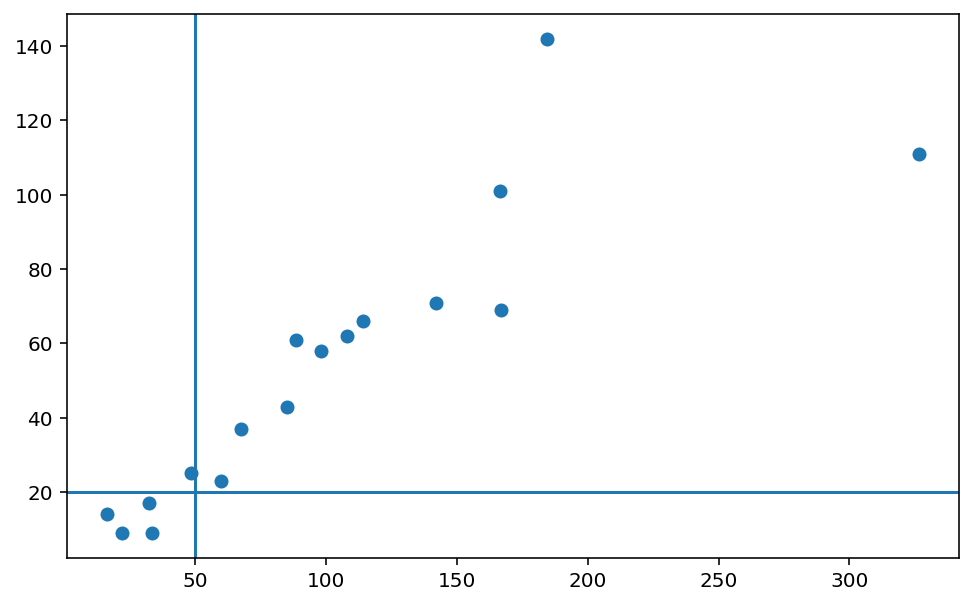

In [35]:
plt.figure(figsize=(8,5))
plt.scatter(gal_df["PNLF N"], gal_df["PNe N"])
# plt.axhline(0.5e10)
plt.axhline(20)
plt.axvline(50)

In [3]:
def linear_reg(x, y, n_sample=500, n_chains=5,n_cores=1):
    data = dict(x=x, y=y)

    with pm.Model() as model:
        # specify glm and pass in data. The resulting linear model, its likelihood and
        # and all its parameters are automatically added to our model.
        pm.glm.GLM.from_formula('y ~ x', data)
        trace = pm.sample(n_sample, chains=n_chains, cores=n_cores)
    
    x_axis = np.linspace(x.min(), x.max(), len(x))
    
    slope_data = trace.get_values("x")
    int_data = trace.get_values("Intercept")

    y_model_glm = [m*x_axis + b for m,b in zip(slope_data, int_data)]
    y_model = np.median(y_model_glm, axis=0)
    perc_16 = np.percentile(y_model_glm, 16, axis=0)
    perc_84 = np.percentile(y_model_glm, 84, axis=0)
    
    
    return [y_model, perc_16, perc_84, x_axis]
        

In [4]:
def boot_func(x, y, boot_num=500):
    boot_zip = np.array([[i,j] for i,j in zip(x, y)])
    
    with NumpyRNGContext(1):
        boot_result = bootstrap(boot_zip, boot_num)
        
    slope = np.ones(num)
    intercept = np.ones(num)
    for n in np.arange(num):
        slope[n], intercept[n], r_value, p_value, std_err_list = stats.linregress(boot_result[n,:,0],boot_result[n,:,1]) 
        
    
    x_axis = np.linspace(x.min(), x.max(), num=len(x))
    
    y_model = [np.array(m*x_axis + b, dtype=float) for m,b in zip(slope, intercept)]
    med_y = np.array(np.nanmedian(y_model,axis=0), dtype=float)
    y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
    y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)
    
    #best_slope, best_int, *stuff = stats.linregress([x_axis[0], x_axis[-1]],[np.nanmedian(med_y,0)[0], np.nanmedian(med_y,0)[-1]])
    
    return med_y, y_16, y_84, x_axis
    
# b_med_y, y_16, y_84, b_x_axis = boot_func(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], 1000)
# plt.plot(b_x_axis, b_med_y, label="bootstrap fit", c="r", alpha=0.7)
# plt.fill_between(b_x_axis, y_16, y_84, alpha=0.3, label="bootstrap confidence interval", color="r")

m = -0.43109107911213695, b = 0.6235628040562768


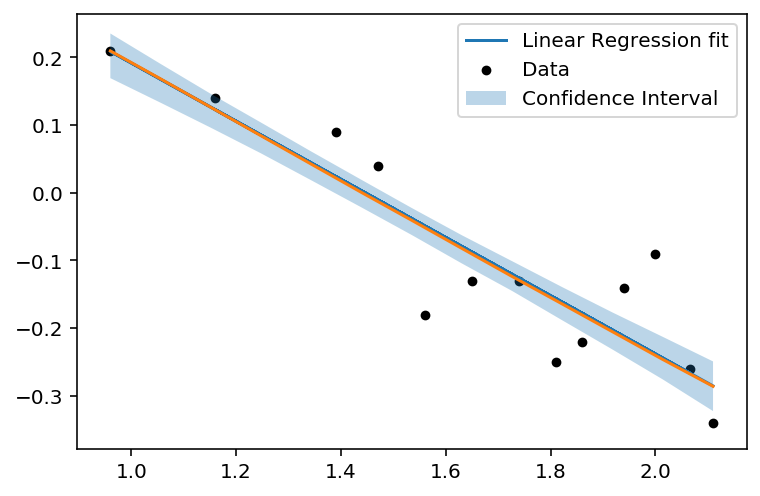

In [95]:

boot_1 = gal_df["FUV-NUV"].loc[pd.notnull(gal_df["FUV-NUV"])]
boot_2 = gal_df["M/H"].loc[pd.notnull(gal_df["FUV-NUV"])]
boot_arr = np.array([[i,j] for i,j in zip(boot_1, boot_2)])

num = 1000

with NumpyRNGContext(1):
    bootresult_1 = bootstrap(boot_arr, num)
#     

slope = np.ones(num)
intercept = np.ones(num)

for n in np.arange(num):
    slope[n], intercept[n], r_value, p_value, std_err_list = stats.linregress(bootresult_1[n,:,0],bootresult_1[n,:,1])
    
# plot data points
plt.scatter(boot_1, boot_2, c="k", label="Data", s=15)

# nan median of slope and intercept
med_slope = np.nanmedian(slope)
med_int = np.nanmedian(intercept)

# plt.ylabel("M/H")
y = med_slope*boot_1 + med_int
plt.plot(boot_1, y, label="Linear Regression fit")
# generate x array, from min to max of x data,
x_axis = np.linspace(boot_1.min(), boot_1.max(), num=len(boot_1))

# generate y model, and get median, 16th and 84th percentiles
y_model = [np.array(m*x_axis + b, dtype=float) for m,b in zip(slope, intercept)]
med_y = np.array([np.nanmedian(y_model,axis=0) for m in y_model], dtype=float)
y_16 = np.array(np.nanpercentile(y_model, 16,axis=0) , dtype=float)
y_84 = np.array(np.nanpercentile(y_model, 84,axis=0) , dtype=float)

plt.plot(x_axis, np.nanmedian(med_y,0))
plt.fill_between(np.array(x_axis, dtype=float), y_16, y_84, alpha=0.3, label="Confidence Interval")
plt.legend()

best_slope, best_int, *stuff = stats.linregress([x_axis[0], x_axis[-1]],[np.nanmedian(med_y,0)[0], np.nanmedian(med_y,0)[-1]])
print(f"m = {best_slope}, b = {best_int}")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (10 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 10 chains: 100%|██████████| 60000/60000 [01:17<00:00, 772.71draws/s] 
There were 219 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4931398803280828, but should be close to 0.8. Try to increase the number of tuning steps.
There were 119 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.616956488323403, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 22 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target

NameError: name 'nperc_16' is not defined

<Figure size 504x504 with 0 Axes>

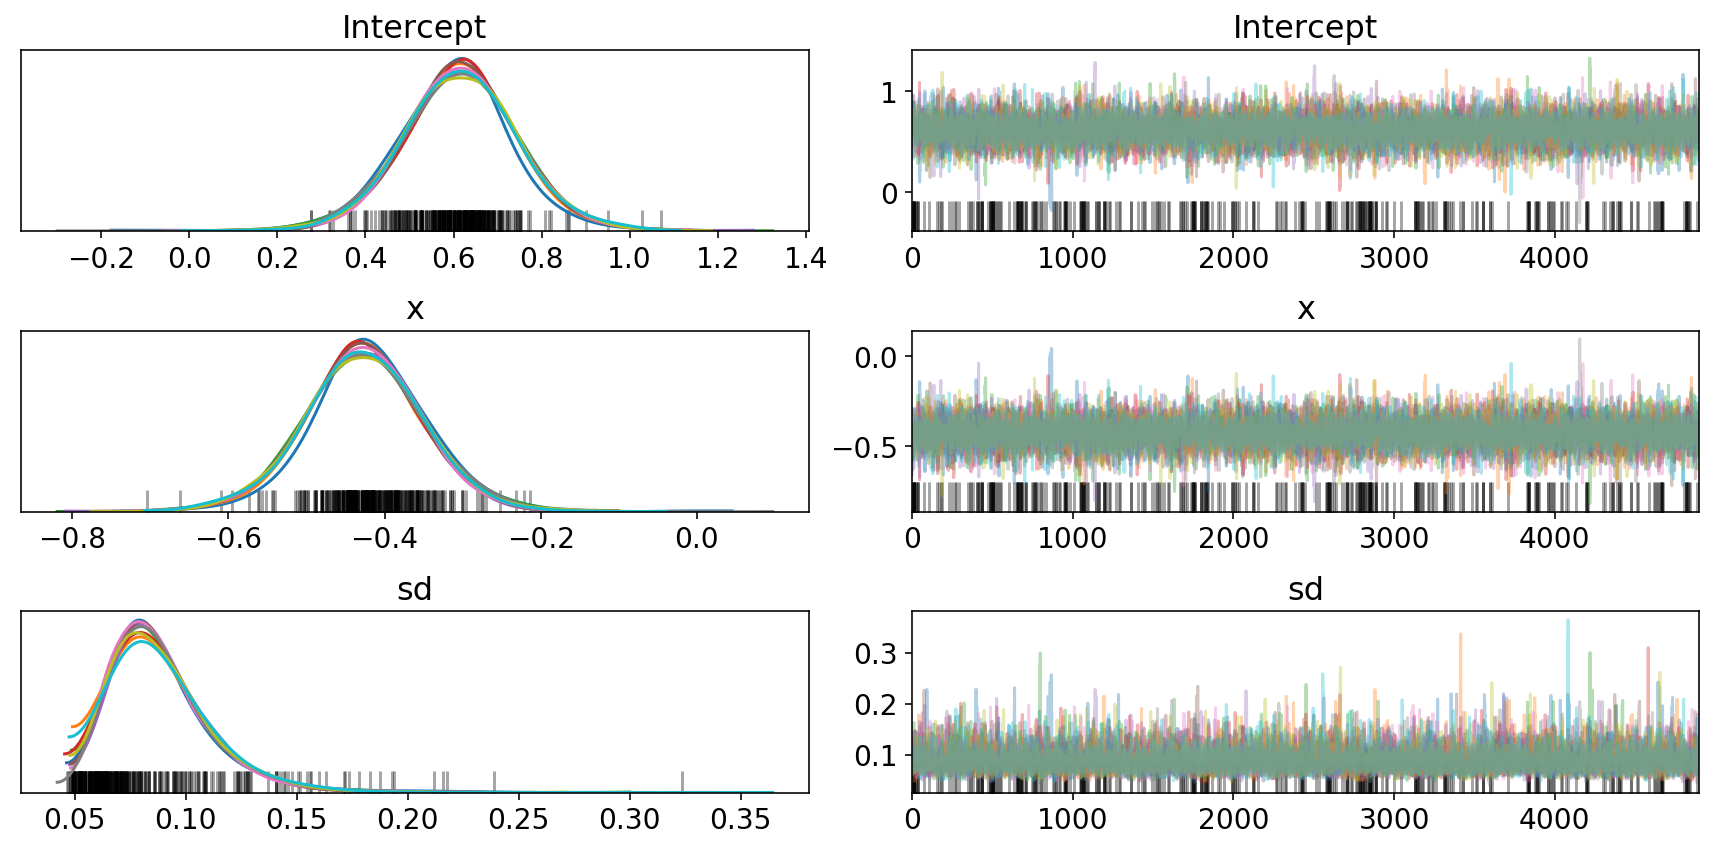

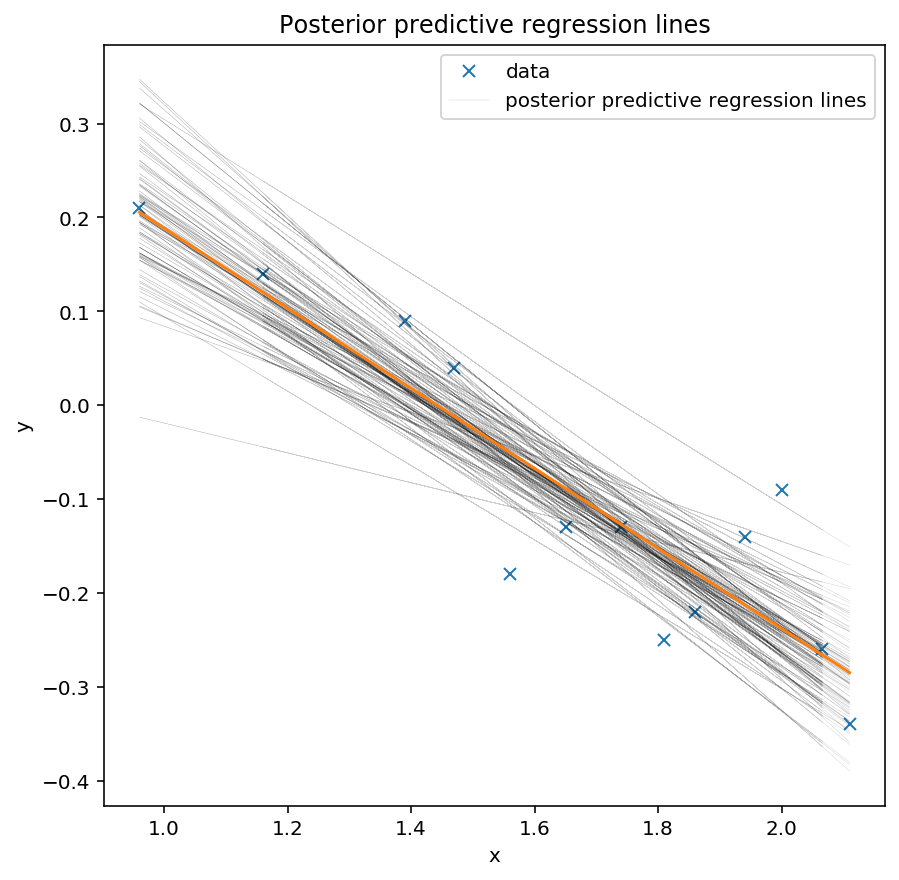

In [108]:
x = gal_df["FUV-NUV"].loc[pd.notnull(gal_df["FUV-NUV"])].values
y = gal_df["M/H"].loc[pd.notnull(gal_df["FUV-NUV"])].values

gal_data = dict(x=x, y=y)

with pm.Model() as model:
    # specify glm and pass in data. The resulting linear model, its likelihood and
    # and all its parameters are automatically added to our model.
    pm.glm.GLM.from_formula('y ~ x', gal_data)
    trace = pm.sample(5000, chains=10, cores=2, tune=1000) 
    
plt.figure(figsize=(7, 7))
pm.traceplot(trace[100:])
plt.tight_layout();

plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,eval=x,
                              label='posterior predictive regression lines', alpha=0.2)
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');



plt.fill_between(x_axis, perc_16, perc_18, alpha=0.4)

print(np.median(trace.get_values("Intercept")))
print(np.median(trace.get_values("x")))

0.6150676778443911
-0.42654620781873565


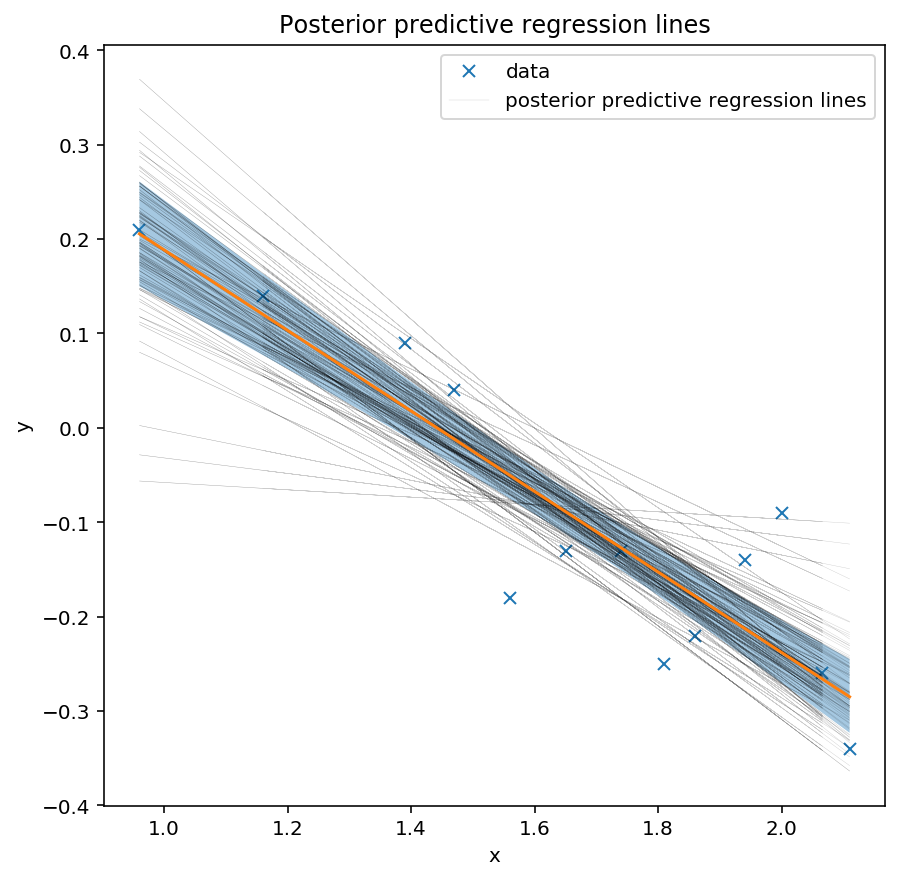

In [123]:
plt.figure(figsize=(7, 7))
plt.plot(x, y, 'x', label='data')
pm.plot_posterior_predictive_glm(trace, samples=100,eval=x,
                              label='posterior predictive regression lines', alpha=0.2)
plt.title('Posterior predictive regression lines')
plt.legend(loc=0)
plt.xlabel('x')
plt.ylabel('y');

x_axis = np.linspace(x.min(), x.max(), len(x))

plt.plot(x_axis, np.median(trace.get_values("x"))*x_axis+np.median(trace.get_values("Intercept")))
slope_data = trace.get_values("x")
int_data = trace.get_values("Intercept")

y_model_glm = [m*x_axis + b for m,b in zip(slope_data, int_data)]
perc_16 = np.percentile(y_model_glm, 16, axis=0)
perc_84 = np.percentile(y_model_glm, 84, axis=0)



plt.fill_between(x_axis, perc_16, perc_84, alpha=0.4)

print(np.median(trace.get_values("Intercept")))
print(np.median(trace.get_values("x")))

# Plot out the galaxy data

In [8]:
things_to_comp_a = ["FUV-R", "FUV-V", "M/H", "FUV-NUV"]
things_to_comp_m = ["M/H", "B-V"]

# PN_filter  = (gal_df["PNe N"]>20) & pd.notnull(gal_df["alpha2.5"])
PN_filter  = pd.notnull(gal_df["alpha2.5"])
FUV_filter = pd.notnull(gal_df["FUV-NUV"])

lin_reg_a = []
lin_reg_m = []

for n,item in enumerate(things_to_comp_a):
    lin_reg_a.append(linear_reg(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], 1500,5,3))
    
for n,item in enumerate(things_to_comp_m):
    lin_reg_m.append(linear_reg(gal_df[item].loc[FUV_filter], gal_df["FUV-NUV"].loc[FUV_filter], 1500,5,3))



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 3 jobs)
NUTS: [sd, x, Intercept]
Sampling 5 chains: 100%|██████████| 10000/10000 [00:30<00:00, 323.59draws/s]
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 138 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5000667289200492, but should be close to 0.8. Try to increase the number of tuning steps.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (5 chains in 3 jobs)
NUTS: [sd

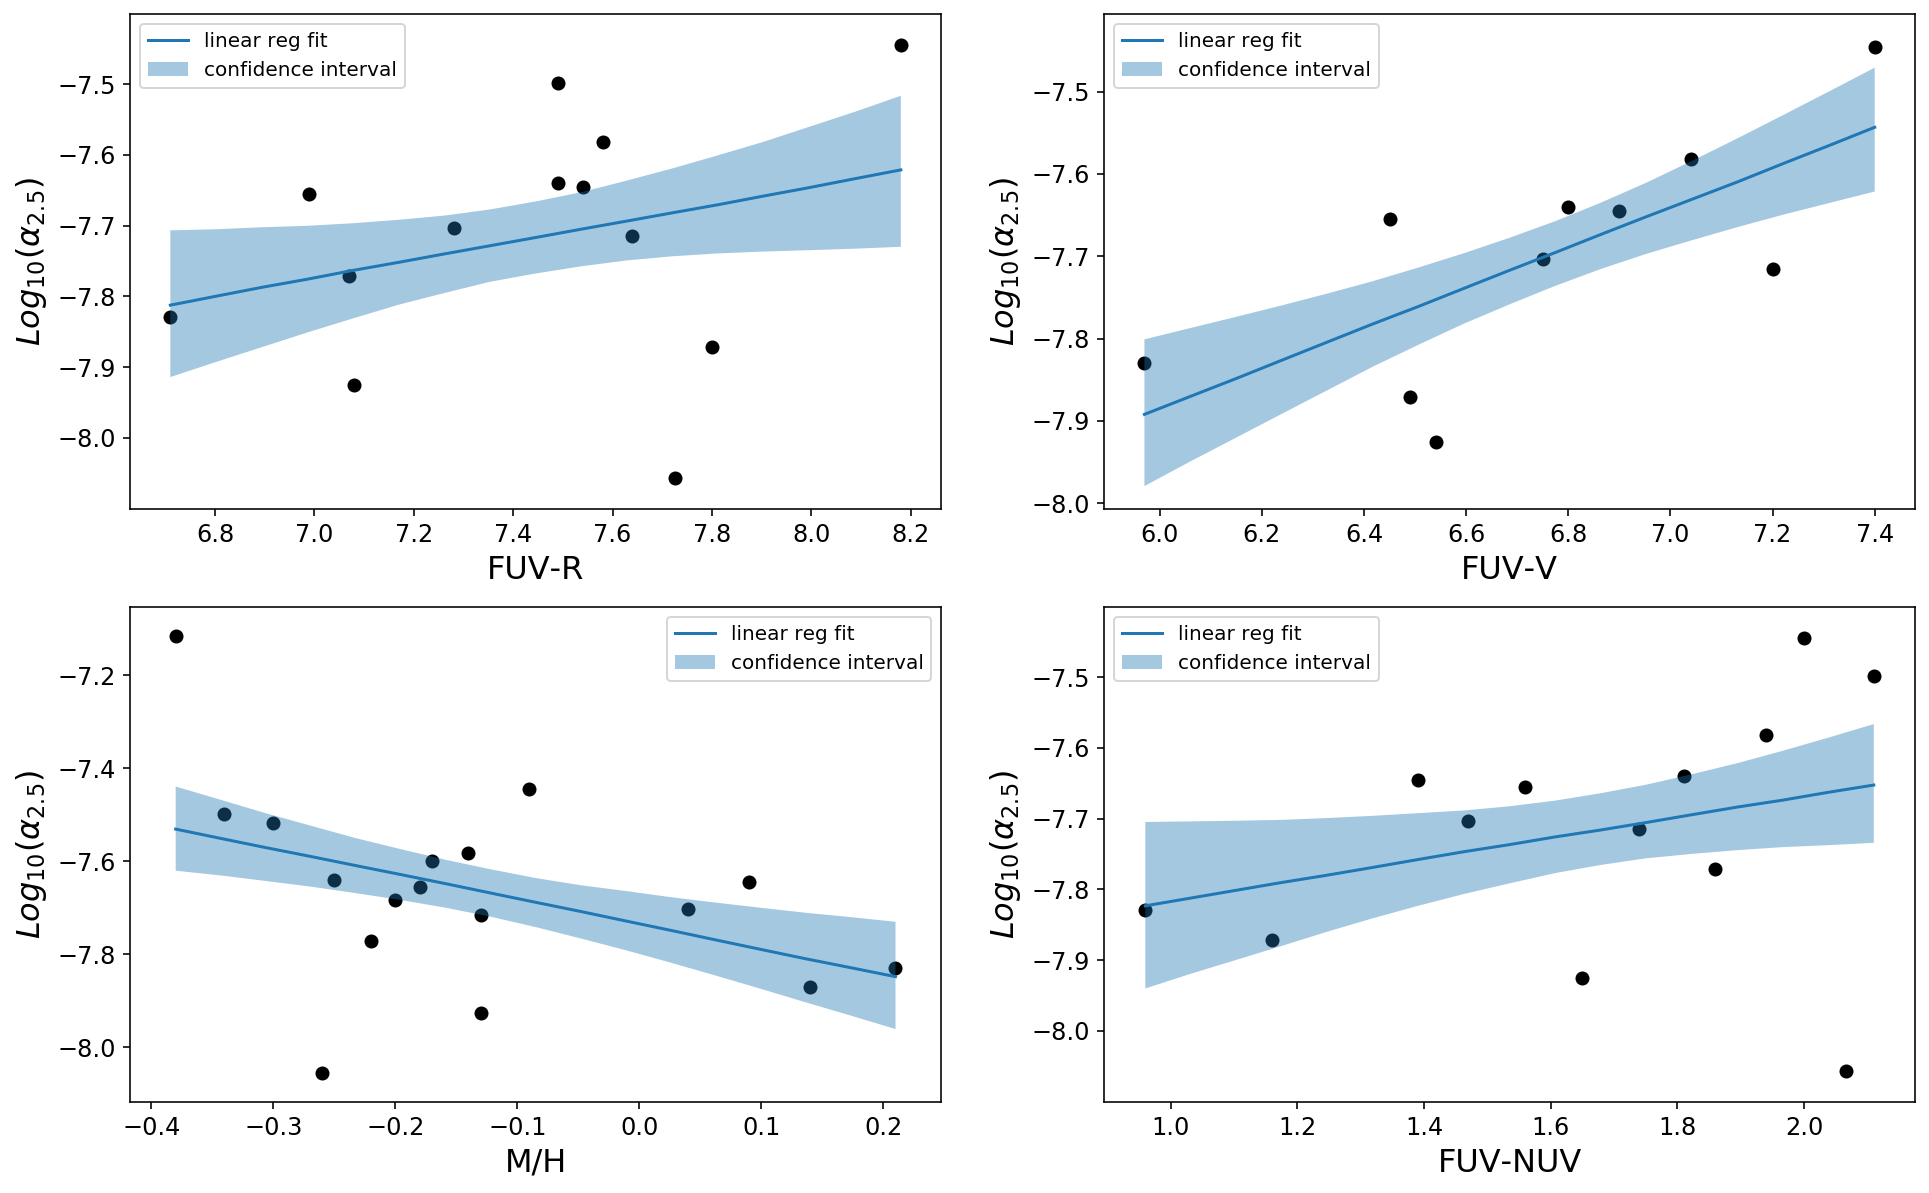

In [9]:
# Plotting
font_s  = 16
label_s = 12
plt.figure(figsize=(16,10))

for n,item in enumerate(things_to_comp_a):
    ax = plt.subplot(2,2,n+1)
    plt.scatter(gal_df[item].loc[PN_filter], gal_df["alpha2.5"].loc[PN_filter], c="k")
    plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=font_s)
    plt.xlabel(item, fontsize=font_s)
    #plt.errorbar(gal_df[item].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
    plt.tick_params(labelsize=label_s)
#     for i, name in enumerate(gal_df["Galaxy"].loc[PN_filter]):
#         ax.annotate(name, (gal_df[item].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="k", size=10)
    plt.plot(lin_reg_a[n][3], lin_reg_a[n][0], label="linear reg fit",)
    plt.fill_between(lin_reg_a[n][3], lin_reg_a[n][1], lin_reg_a[n][2], alpha=0.4, label="confidence interval")
    
    plt.legend()

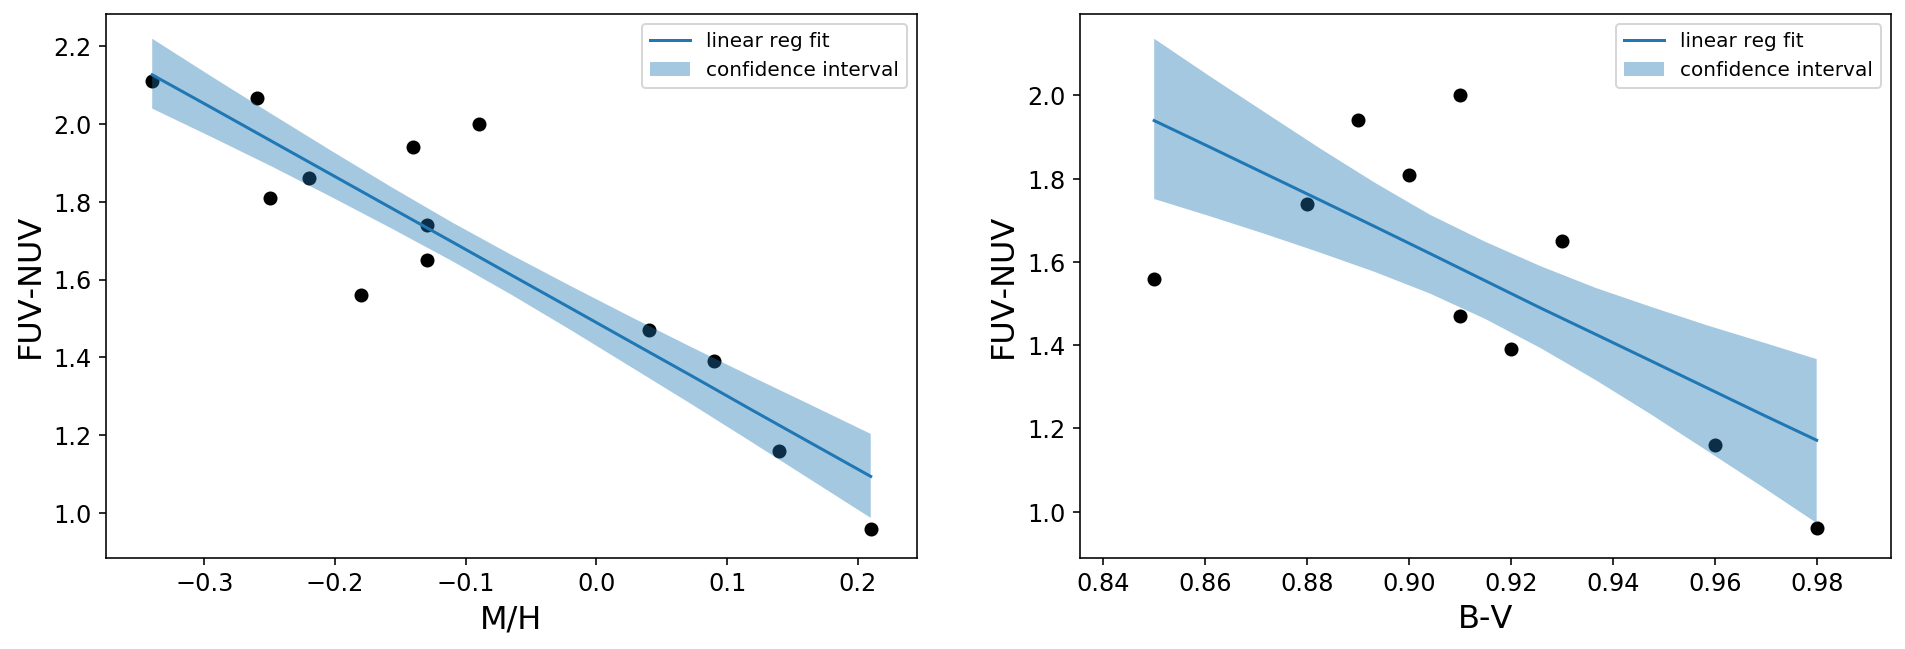

In [10]:
plt.figure(figsize=(16,5))
for n,item in enumerate(things_to_comp_m):
    ax = plt.subplot(1,2,n+1)
    plt.scatter(gal_df[item].loc[FUV_filter], gal_df["FUV-NUV"].loc[FUV_filter], c="k")
    plt.ylabel("FUV-NUV", fontsize=font_s)
    plt.xlabel(item, fontsize=font_s)
    #plt.errorbar(gal_df[item].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
    plt.tick_params(labelsize=label_s)
#     for i, name in enumerate(gal_df["Galaxy"].loc[PN_filter]):
#         ax.annotate(name, (gal_df[item].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="k", size=10)
    plt.plot(lin_reg_m[n][3], lin_reg_m[n][0], label="linear reg fit",)
    plt.fill_between(lin_reg_m[n][3], lin_reg_m[n][1], lin_reg_m[n][2], alpha=0.4, label="confidence interval")
    
    plt.legend()

#plt.savefig("Plots/FUV_minus_NUV_comp.png")

In [ ]:
f_size = 22
l_size = 15

plt.figure(figsize=(20,26))

ax1 = plt.subplot(4,2,1) # FUV
plt.scatter(gal_df["FUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("FUV mag", fontsize=f_size)
plt.errorbar(gal_df["FUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=gal_df["FUV err"].loc[gal_df["PNe N"]>20], yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#ax1.set_ylim(-8,-7)
#ax1 = plt.gca()
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax1.annotate(name, (gal_df["FUV"].loc[gal_df["Galaxy"]==name]+0.03, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - NUV
ax2 = plt.subplot(4,2,2) 
plt.scatter(gal_df["FUV-NUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["FUV-NUV"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=(gal_df["FUV err"].loc[gal_df["PNe N"]>20]**2+gal_df["NUV err"].loc[gal_df["PNe N"]>20]**2)**1/2, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - NUV", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax2.annotate(name, (gal_df["FUV-NUV"].loc[gal_df["Galaxy"]==name]-0.02,  gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - V
ax3 = plt.subplot(4,2,3) 
plt.scatter(gal_df["FUV-V"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], label="F3D")
#plt.scatter(B_FUV_m_V, Buzzoni_log_a-1, c="r", label=r"Buzzoni 2006 $\alpha$")
plt.errorbar(gal_df["FUV-V"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=(gal_df["NUV err"].loc[gal_df["PNe N"]>20]**2+gal_df["Vmag err"].loc[gal_df["PNe N"]>20]**2)**1/2, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
#plt.errorbar(B_FUV_m_V, Buzzoni_log_a-1, xerr=B_Vmag_err+B_FUV_err, yerr=0.08, c="r", ls="None", label=None)
plt.xlabel("FUV - V (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
#plt.legend(fontsize=l_size, loc=2)
#plt.xlim(4,)
ax3.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax3.annotate(name, (gal_df["FUV-V"].loc[gal_df["Galaxy"]==name]-0.02,  gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)

# FUV - R
ax4 = plt.subplot(4,2,4) 
plt.scatter(gal_df["FUV-R"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["FUV-R"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.1, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.xlabel("FUV - R (mag)", fontsize=f_size)
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax4.annotate(name, (gal_df["FUV-R"].loc[gal_df["Galaxy"]==name]-0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)
    
# Rmag vs alpha
ax5 = plt.subplot(4,2,5)
plt.scatter(gal_df["Rmag"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel("R mag", fontsize=f_size)
plt.errorbar(gal_df["Rmag"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.1, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
#plt.ylim(-8,-7)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax5.annotate(name, (gal_df["Rmag"].loc[gal_df["Galaxy"]==name]-0.14, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.02), color="black", size=10)
    
ax6 = plt.subplot(4,2,6)
plt.scatter(gal_df["sigma"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$\sigma_{e} \ (km s^{-1})$ ", fontsize=f_size)
plt.errorbar(gal_df["sigma"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=9.0, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax6.annotate(name, (gal_df["sigma"].loc[gal_df["Galaxy"]==name]-2.5, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.01), color="black", size=10)
    
    
ax7 = plt.subplot(4,2,7) # M/H metallicity
plt.scatter(gal_df["M/H"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["M/H"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.035, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[M/H]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax7.annotate(name, (gal_df["M/H"].loc[gal_df["Galaxy"]==name]+0.01, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.003), color="black", size=10)
    
ax8 = plt.subplot(4,2,8)
plt.scatter(gal_df["Mg/Fe"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20])
plt.errorbar(gal_df["Mg/Fe"].loc[gal_df["PNe N"]>20], gal_df["alpha2.5"].loc[gal_df["PNe N"]>20], xerr=0.01, yerr=gal_df["alpha2.5 err"].loc[gal_df["PNe N"]>20], ls="None")
plt.ylabel(r"$Log_{10}(\alpha_{2.5})$", fontsize=f_size)
plt.xlabel(r"$[Mg/Fe]_{0.5R_{e}}$ dex", fontsize=f_size)
plt.tick_params(labelsize=l_size)
for i, name in enumerate(gal_df["Galaxy"].loc[gal_df["PNe N"]>20]):
    ax8.annotate(name, (gal_df["Mg/Fe"].loc[gal_df["Galaxy"]==name]+0.004, gal_df["alpha2.5"].loc[gal_df["Galaxy"]==name]+0.005), color="black", size=10)
    
plt.tight_layout()

#plt.savefig("Plots/Pandas_alpha_comparison_plots.pdf", bbox_inches='tight')
#plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots_filtered.png", bbox_inches='tight')
# plt.savefig("Plots/Pandas_PNLF_alpha_comparison_plots.png", bbox_inches='tight')
#plt.savefig("Plots/Pandas_lit_alpha_comparison_plots.png", bbox_inches='tight')
